In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# replace with your own root directory
root="./data"
train_set_path = "/train_set/train_set/"
test_set_path = "/test_set"

In [4]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [6]:
train_dataset = ImageFolder(root+train_set_path, transform = transform)
test_dataset = ImageFolder(root+test_set_path, transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
# Loading the Classes
classes  = list()
labels = open(root+"/mapping.txt")
for map in labels:
    key, value =map.split()
    classes.append(value)
classes = tuple(classes) 
print(classes)
len_class = len(classes)
print(len_class)

('baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella')
30


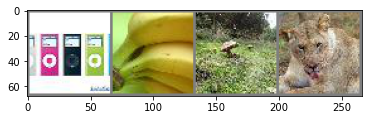

In [15]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [45]:
conv1 = nn.Conv2d(3,6,5)
pool = nn.MaxPool2d(2,2)
relu = nn.ReLU()

conv2 = nn.Conv2d(6,16,5)
conv3 = nn.Conv2d(16,32,5)

#flatten = nn.Flatten()
print(images.shape)

x = conv1(images)
print("Conv1 layer - "+str(x.shape))

x = pool(x)
print("Pooling layer - "+str(x.shape))

x = relu(x)
print("RELU layer - "+str(x.shape))

x = conv2(x)
print("Conv2 layer - "+str(x.shape))

x = pool(x)
print("Pooling2 layer - "+str(x.shape))

x = conv3(x)
print("Conv3 layer - "+str(x.shape))

x = pool(x)
print("Pooling3 layer - "+str(x.shape))

x = x.view(-1, 32*4*4)
print("x layer - "+str(x.shape))
# x = flatten(x)
# print("flatten layer - "+str(x.shape))

y = 4
fc1 = nn.Linear(32*y*y, 128)
x = fc1(x)
print("fully connected 1 layer - "+str(x.shape))

fc2 = nn.Linear(128, 84)
x = fc2(x)
print("fully connected 2 layer - "+str(x.shape))

fc3 = nn.Linear(84, len_class)
x = fc3(x)
print("fully connected 3 layer - "+str(x.shape))


torch.Size([4, 3, 64, 64])
Conv1 layer - torch.Size([4, 6, 60, 60])
Pooling layer - torch.Size([4, 6, 30, 30])
RELU layer - torch.Size([4, 6, 30, 30])
Conv2 layer - torch.Size([4, 16, 26, 26])
Pooling2 layer - torch.Size([4, 16, 13, 13])
Conv3 layer - torch.Size([4, 32, 9, 9])
Pooling3 layer - torch.Size([4, 32, 4, 4])
x layer - torch.Size([4, 512])
fully connected 1 layer - torch.Size([4, 128])
fully connected 2 layer - torch.Size([4, 84])
fully connected 3 layer - torch.Size([4, 30])


In [48]:
cnn = nn.Sequential (
    nn.Conv2d(3,6,5),
    nn.MaxPool2d(2,2),
    nn.ReLU(),
    nn.Conv2d(6,16,5),
    nn.MaxPool2d(2,2),
    nn.Conv2d(16,32,5),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(32*4*4,128),
    nn.Linear(128, 84),
    nn.Linear(84, len_class)
)

cnn = cnn.to(device)
for param in cnn.parameters():
    print(param.shape)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([128, 512])
torch.Size([128])
torch.Size([84, 128])
torch.Size([84])
torch.Size([30, 84])
torch.Size([30])


In [50]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr = learning_rate)

In [54]:
%%time
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        image_s, label_s = data
        images, labels = image_s.to(device), label_s.to(device)
        
        outputs = cnn(images)
        loss_fn = loss(outputs, labels)
        
        optimizer.zero_grad()
        loss_fn.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss_fn.item():.4f}')
            
print('Finished Training')
torch.save(cnn.state_dict(), root+'/cnn1.pt')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(30)]
    n_class_samples = [0 for i in range(30)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(30):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


2013it [00:19, 101.24it/s]

Epoch [1/5], Step [2000/3375], Loss: 2.6883


3375it [00:32, 105.38it/s]
2008it [00:18, 111.56it/s]

Epoch [2/5], Step [2000/3375], Loss: 3.1238


3375it [00:31, 107.67it/s]
2018it [00:19, 108.54it/s]

Epoch [3/5], Step [2000/3375], Loss: 2.5790


3375it [00:31, 105.69it/s]
2021it [00:20, 111.49it/s]

Epoch [4/5], Step [2000/3375], Loss: 1.6831


3375it [00:32, 103.63it/s]
2014it [00:18, 110.31it/s]

Epoch [5/5], Step [2000/3375], Loss: 2.7007


3375it [00:30, 109.24it/s]


Finished Training
Accuracy of the network: 3.1333333333333333 %
Accuracy of baboon: 3.1333333333333333 %


ZeroDivisionError: float division by zero